This notebook generates random synthetic fMRI data and a random behavioral regressor, and performs a standard univariate analysis to find correlations between the two.  It is meant to demonstrate how easy it is to find seemingly impressive correlations with fMRI data when multiple tests are not properly controlled for.  

In order to run this code, you must first install the standard Scientific Python stack (e.g. using [anaconda](https://www.continuum.io/downloads)) along with following additional dependencies:
* [nibabel](http://nipy.org/nibabel/)
* [nilearn](http://nilearn.github.io)
* [statsmodels](http://statsmodels.sourceforge.net)
* [nipype](http://nipype.readthedocs.io/en/latest/)

In addition, this notebook assumes that [FSL](http://fsl.fmrib.ox.ac.uk/fsl/fslwiki/) is installed and that the FSLDIR environment variable is defined.


In [57]:
import numpy
import nibabel
import os
import nilearn.plotting
import matplotlib.pyplot as plt
from statsmodels.regression.linear_model import OLS
import nipype.interfaces.fsl as fsl
import scipy.stats

if not 'FSLDIR' in os.environ.keys():
    raise Exception('This notebook requires that FSL is installed and the FSLDIR environment variable is set')

%matplotlib inline


Set up default parameters.  We use 32 subjects, which is the median sample size of the set of fMRI studies published between 2011 and 2015 that were estimated from Neurosynth in the paper.  We use a heuristic correction for multiple comparisons of p<0.001 and 10 voxels, like that show by Eklund et al. (2016, PNAS) to result in Type I error rates of 0.6-0.9.

In [58]:
pthresh=0.001  # cluster forming threshold
cthresh=10     # cluster extent threshold
nsubs=32       # number of subjects

In order to recreate the figure from the paper exactly, we need to fix the random seed so that it will generate exactly the same random data.  If you wish to generate new data, then set the recreate_paper_figure variable to False and rerun the notebook.


In [59]:
recreate_paper_figure=True
if recreate_paper_figure:
    seed=61974
else:
    seed=numpy.ceil(numpy.random.rand()*100000).astype('int')
    print(seed)

numpy.random.seed(seed)

Use the standard MNI152 2mm brain mask as the mask for the generated data



In [60]:
maskimg=os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain_mask.nii.gz')
mask=nibabel.load(maskimg)
maskdata=mask.get_data()
maskvox=numpy.where(maskdata>0)
print('Mask includes %d voxels'%len(maskvox[0]))

Mask includes 228483 voxels


Generate a dataset for each subject.  fMRI data within the mask are generated using a Gaussian distribution (mean=1000, standard deviation=100).  Behavioral data are generated using a Gaussian distribution (mean=100, standard deviation=1).



In [61]:
imgmean=1000    # mean activation within mask
imgstd=100      # standard deviation of noise within mask
behavmean=100   # mean of behavioral regressor
behavstd=1      # standard deviation of behavioral regressor

data=numpy.zeros((maskdata.shape + (nsubs,)))

for i in range(nsubs):
    tmp=numpy.zeros(maskdata.shape)
    tmp[maskvox]=numpy.random.randn(len(maskvox[0]))*imgstd+imgmean
    data[:,:,:,i]=tmp

newimg=nibabel.Nifti1Image(data,mask.get_affine(),mask.get_header())
newimg.to_filename('fakedata.nii.gz')
regressor=numpy.random.randn(nsubs,1)*behavstd+behavmean
numpy.savetxt('regressor.txt',regressor)

Spatially smooth data using a 6 mm FWHM Gaussian kernel

In [62]:
smoothing_fwhm=6 # FWHM in millimeters

smooth=fsl.IsotropicSmooth(fwhm=smoothing_fwhm,
                           in_file='fakedata.nii.gz',
                           out_file='fakedata_smooth.nii.gz')
smooth.run()

Use FSL's GLM tool to run a regression at each voxel

In [63]:
glm = fsl.GLM(in_file='fakedata_smooth.nii.gz', 
              design='regressor.txt', 
              out_t_name='regressor_tstat.nii.gz',
             demean=True)
glm.run()

Use FSL's cluster tool to identify clusters of activation that exceed the specified cluster-forming threshold

In [64]:
tcut=scipy.stats.t.ppf(1-pthresh,nsubs-1)
cl = fsl.Cluster()
cl.inputs.threshold = tcut
cl.inputs.in_file = 'regressor_tstat.nii.gz'
cl.inputs.out_index_file='tstat_cluster_index.nii.gz'
results=cl.run()

Generate a plot showing the brain-behavior relation from the top cluster

Found 73 clusters exceeding p<0.001 and 10 voxel extent threshold
Largest cluster: correlation=0.686, extent = 22 voxels


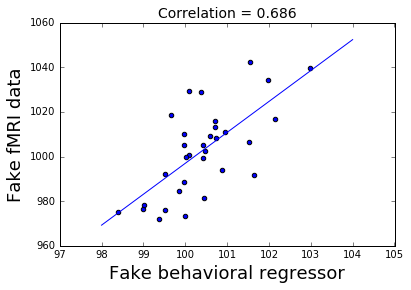

In [65]:
clusterimg=nibabel.load(cl.inputs.out_index_file)
clusterdata=clusterimg.get_data()
indices=numpy.unique(clusterdata)

clustersize=numpy.zeros(len(indices))
clustermean=numpy.zeros((len(indices),nsubs))
indvox={}
for c in range(1,len(indices)):
    indvox[c]=numpy.where(clusterdata==c)    
    clustersize[c]=len(indvox[c][0])
    for i in range(nsubs):
        tmp=data[:,:,:,i]
        clustermean[c,i]=numpy.mean(tmp[indvox[c]])
corr=numpy.corrcoef(regressor.T,clustermean[-1])

print('Found %d clusters exceeding p<%0.3f and %d voxel extent threshold'%(c,pthresh,cthresh))
print('Largest cluster: correlation=%0.3f, extent = %d voxels'%(corr[0,1],len(indvox[c][0])))

# set cluster to show - 0 is the largest, 1 the second largest, and so on
cluster_to_show=0

# translate this variable into the index of indvox
cluster_to_show_idx=len(indices)-cluster_to_show-1

# plot the (circular) relation between fMRI signal and 
# behavioral regressor in the chosen cluster

plt.scatter(regressor.T,clustermean[cluster_to_show_idx])
plt.title('Correlation = %0.3f'%corr[0,1],fontsize=14)
plt.xlabel('Fake behavioral regressor',fontsize=18)
plt.ylabel('Fake fMRI data',fontsize=18)
m, b = numpy.polyfit(regressor[:,0], clustermean[cluster_to_show_idx], 1)
axes = plt.gca()
X_plot = numpy.linspace(axes.get_xlim()[0],axes.get_xlim()[1],100)
plt.plot(X_plot, m*X_plot + b, '-')
plt.savefig('scatter.png',dpi=600)

Generate a thresholded statistics image for display

In [66]:
tstat=nibabel.load('regressor_tstat.nii.gz').get_data()
thresh_t=clusterdata.copy()
cutoff=numpy.min(numpy.where(clustersize>cthresh))
thresh_t[thresh_t<cutoff]=0
thresh_t=thresh_t*tstat
thresh_t_img=nibabel.Nifti1Image(thresh_t,mask.get_affine(),mask.get_header())

Generate a figure showing the location of the selected activation focus.

/Users/poldrack/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app
/Users/poldrack/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
/Users/poldrack/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


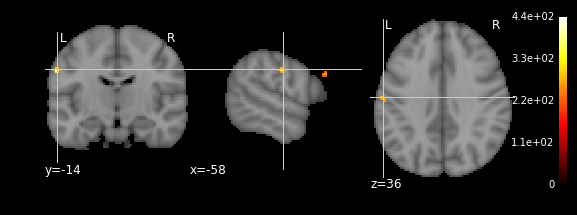

In [67]:
mid=len(indvox[cluster_to_show_idx][0])/2
coords=numpy.array([indvox[cluster_to_show_idx][0][mid],
                    indvox[cluster_to_show_idx][1][mid],
                    indvox[cluster_to_show_idx][2][mid],1]).T
mni=mask.get_qform().dot(coords)
nilearn.plotting.plot_stat_map(thresh_t_img,
        os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz'),
                              threshold=cl.inputs.threshold,
                               cut_coords=mni[:3])
plt.savefig('slices.png',dpi=600)